In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, PrecisionRecallDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb 
import warnings
warnings.filterwarnings('ignore')

In [2]:
class OfflineRLEnvironment:
    """
    Simulates fraud detection environment from historical data
    """
    def __init__(self, X, y, reward_config=None):
        self.X = X
        self.y = y
        self.current_idx = 0
        self.done = False
        
        # Reward configuration
        raw_reward_config = reward_config or {
            'true_positive': 100,    # Correctly detecting fraud
            'true_negative': 1,      # Correctly identifying legitimate
            'false_positive': -75,   # False alarm cost
            'false_negative': -100    # Missing fraud cost
        }

        # We scale them to be in a smaller range by dividing by the largest absolute value.
        self.reward_scale = 100.0 
        self.reward_config = {k: v / self.reward_scale for k, v in raw_reward_config.items()}
        
        print("Normalized Reward Config:", self.reward_config)

    
    def reset(self):
        self.current_idx = 0
        self.done = False
        return self.X[self.current_idx]
    
    def step(self, action):
        if self.current_idx >= len(self.X) - 1:
            self.done = True
            return None, 0, True
        
        # Calculate reward based on action vs true label
        true_label = self.y[self.current_idx]
        
        if action == 1 and true_label == 1:  # True Positive
            reward = self.reward_config['true_positive']
        elif action == 0 and true_label == 0:  # True Negative
            reward = self.reward_config['true_negative']
        elif action == 1 and true_label == 0:  # False Positive
            reward = self.reward_config['false_positive']
        else:  # False Negative (action == 0 and true_label == 1)
            reward = self.reward_config['false_negative']
        
        self.current_idx += 1
        next_state = self.X[self.current_idx] if self.current_idx < len(self.X) else None
        
        return next_state, reward, self.done

In [3]:
class DQNAgent(nn.Module):
    """
    Deep Q-Network for fraud detection decisions
    """
    def __init__(self, state_dim, hidden_dims=[256, 128, 64]):
        super(DQNAgent, self).__init__()
        
        layers = []
        prev_dim = state_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.2)
            ])
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, 2))  # 2 actions: 0 (legitimate), 1 (fraud)
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)


In [4]:
class OfflineFraudDetectionRL:
    """
    Main class for offline RL fraud detection
    """
    def __init__(self, reward_config=None):
        self.scaler = StandardScaler()
        self.label_encoders = {}
        self.agent = None
        self.env = None
        self.reward_config = reward_config
    
    def preprocess_data(self, df):
        """Reverted to the simple, high-performing preprocessing."""
        print("Preprocessing data (simple version)...")
        
        # We drop TransactionDT as it's just an index
        if 'TransactionDT' in df.columns:
            df = df.drop('TransactionDT', axis=1)

        # Handle missing values
        df = df.fillna(df.median(numeric_only=True))
        df = df.fillna('unknown')
        
        # Encode categorical variables
        categorical_cols = df.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            if col != 'isFraud':
                le = LabelEncoder()
                df[col] = le.fit_transform(df[col].astype(str))
                self.label_encoders[col] = le
        
        # Separate features and target
        if 'isFraud' in df.columns:
            X = df.drop('isFraud', axis=1)
            y = df['isFraud']
        else:
            X = df.iloc[:, :-1]
            y = df.iloc[:, -1]
        
        # Save feature names for later 
        self.feature_names_ = X.columns.tolist()

        # Scale features
        X_scaled = self.scaler.fit_transform(X)
        
        print(f"Data shape after preprocessing: {X_scaled.shape}")
        return X_scaled, y.values
    
    
    def create_offline_dataset(self, X, y, sequence_length=10):
        """Create a balanced sequential dataset for offline RL using under-sampling."""
        print("Creating balanced offline RL dataset...")
        
        # Separate indices for fraud and non-fraud
        fraud_indices = np.where(y == 1)[0]
        non_fraud_indices = np.where(y == 0)[0]
        
        # Under-sample non-fraud indices to be, 5x the number of fraud indices
        num_fraud = len(fraud_indices)
        sampled_non_fraud_indices = np.random.choice(non_fraud_indices, size=num_fraud * 5, replace=False)
        
        # Combine and shuffle indices
        balanced_indices = np.concatenate([fraud_indices, sampled_non_fraud_indices])
        np.random.shuffle(balanced_indices)
    
        states, actions, rewards, next_states, dones = [], [], [], [], []
        temp_env = OfflineRLEnvironment(X, y, self.reward_config)
    
        # Use the balanced indices to create the dataset
        for i in balanced_indices:
            # Ensure we don't go out of bounds
            if i >= len(X) - 1:
                continue
    
            state = X[i]
            action = y[i] # Historical action
            
            temp_env.current_idx = i
            _, reward, _ = temp_env.step(action)
            
            next_state = X[i + 1]
            done = (i == len(X) - 2)
            
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)
    
        return (np.array(states), np.array(actions), np.array(rewards), 
                np.array(next_states), np.array(dones))
        
    def train(self, X, y, epochs=100, batch_size=256, target_update_freq=10):
        """Train the offline RL agent"""
        print("Training offline RL agent...")
        
        # Create offline dataset
        offline_data = self.create_offline_dataset(X, y)
        states, actions, rewards, next_states, dones = offline_data
        
        # Initialize agent
        state_dim = X.shape[1]
        self.agent = ConservativeQAgent(state_dim)
        
        # Training loop
        dataset_size = len(states)
        
        for epoch in range(epochs):
            epoch_losses = []
            epoch_dqn_losses = []
            epoch_cql_losses = []
            
            # Shuffle data
            indices = np.random.permutation(dataset_size)
            
            for i in range(0, dataset_size, batch_size):
                batch_indices = indices[i:i+batch_size]
                
                batch = (
                    states[batch_indices],
                    actions[batch_indices],
                    rewards[batch_indices],
                    next_states[batch_indices],
                    dones[batch_indices]
                )
                
                total_loss, dqn_loss, cql_loss = self.agent.train_step(batch)
                epoch_losses.append(total_loss)
                epoch_dqn_losses.append(dqn_loss)
                epoch_cql_losses.append(cql_loss)
            
            # Update target network
            if epoch % target_update_freq == 0:
                self.agent.update_target_network()
            
            if epoch % 20 == 0:
                avg_loss = np.mean(epoch_losses)
                avg_dqn = np.mean(epoch_dqn_losses)
                avg_cql = np.mean(epoch_cql_losses)
                print(f"Epoch {epoch}: Total Loss: {avg_loss:.4f}, "
                      f"DQN Loss: {avg_dqn:.4f}, CQL Loss: {avg_cql:.4f}")
    
    def evaluate(self, X_test, y_test):
        """Evaluate the trained agent"""
        print("Evaluating agent...")
        
        predictions = []
        probabilities = []
        
        for i in range(len(X_test)):
            action = self.agent.select_action(X_test[i], epsilon=0.0)
            predictions.append(action)
            
            # Get Q-values as proxy for probabilities
            with torch.no_grad():
                state_tensor = torch.FloatTensor(X_test[i]).unsqueeze(0).to(self.agent.device)
                q_values = self.agent.q_network(state_tensor)
                prob = torch.softmax(q_values, dim=1)[0, 1].item()
                probabilities.append(prob)
        
        # Calculate metrics
        auc_score = roc_auc_score(y_test, probabilities)
        print(f"\nAUC Score: {auc_score:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, predictions))
        
        return predictions, probabilities, auc_score

In [5]:
class ConservativeQAgent:
    """
    Conservative Q-Learning (CQL) agent for offline RL.
    
    """
    def __init__(self, state_dim, lr=0.0001, gamma=0.95, alpha=2.5, tau=0.005, network_class=DQNAgent):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.q_network = network_class(state_dim).to(self.device)
        self.target_network = network_class(state_dim).to(self.device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr, weight_decay=1e-4)
        
        self.gamma = gamma
        self.alpha = alpha
        self.tau = tau
        
        self.update_target_network()
        self.reward_scale = 0.1
    
    def update_target_network(self):
        
        for target_param, param in zip(self.target_network.parameters(), self.q_network.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
    
    def select_action(self, state, epsilon=0.0):
        
        if np.random.random() < epsilon:
            return np.random.randint(2)
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            # If the network is recurrent, we only care about the q_values part of the output
            output = self.q_network(state_tensor)
            q_values = output[0] if isinstance(output, tuple) else output
            return q_values.argmax().item()
    
    def train_step(self, batch):
        states, actions, rewards, next_states, dones = batch
        
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device) * self.reward_scale
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.BoolTensor(dones).to(self.device)
        
       
        # The q_network might return a tuple (q_values, hidden_state). We only need the q_values.
        output = self.q_network(states)
        current_q_values = output[0] if isinstance(output, tuple) else output
    
        
        current_q = current_q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # Target Q values with double DQN
        with torch.no_grad():
            next_output = self.q_network(next_states)
            next_q_values = next_output[0] if isinstance(next_output, tuple) else next_output
            
            next_actions = next_q_values.argmax(1)
            
            target_output = self.target_network(next_states)
            next_q_target_values = target_output[0] if isinstance(target_output, tuple) else target_output

            next_q_target = next_q_target_values.gather(1, next_actions.unsqueeze(1)).squeeze(1)
            target_q = rewards + (self.gamma * next_q_target * ~dones)
        
        target_q = torch.clamp(target_q, -100, 100)
        dqn_loss = nn.SmoothL1Loss()(current_q, target_q)
        
        # Conservative Q-Learning regularization
        if dqn_loss.item() < 10.0:
            dataset_q_values = current_q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
            ood_q_values = torch.logsumexp(current_q_values, dim=1)
            cql_loss = (ood_q_values - dataset_q_values).mean()
            cql_loss = torch.clamp(cql_loss, 0, 10)
        else:
            cql_loss = torch.tensor(0.0, device=self.device)
        
        total_loss = dqn_loss + self.alpha * cql_loss
        
        self.optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), max_norm=1.0)
        self.optimizer.step()
        self.update_target_network()
        
        return total_loss.item(), dqn_loss.item(), cql_loss.item()

In [6]:
def load_ieee_cis_data(train_transaction_path, train_identity_path=None):
    """
    Load and preprocess real IEEE CIS dataset
    
    Args:
        train_transaction_path: Path to train_transaction.csv
        train_identity_path: Path to train_identity.csv (optional)
    
    Returns:
        Preprocessed DataFrame
    """
    # Load transaction data
    df_train = pd.read_csv(train_transaction_path)
    
    # Load identity data if available
    if train_identity_path:
        df_identity = pd.read_csv(train_identity_path)
        df_train = df_train.merge(df_identity, on='TransactionID', how='left')
    
    # Drop unnecessary columns
    if 'TransactionID' in df_train.columns:
        df_train = df_train.drop('TransactionID', axis=1)
    
    return df_train

In [9]:
from sklearn.metrics import precision_recall_curve, f1_score

def find_optimal_threshold(y_true, y_pred_probs):
    """Find the optimal threshold that maximizes the F1 score."""
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_probs)
    
    # We want to find the threshold that gives the best F1 score
    f1_scores = (2 * precision * recall) / (precision + recall)
    
    # The last precision and recall values are 1. and 0. respectively and do not have a corresponding threshold.
    f1_scores = f1_scores[:-1]
    
    best_f1_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_f1_idx]
    
    print(f"Best F1 Score: {f1_scores[best_f1_idx]:.4f} at Threshold: {best_threshold:.4f}")
    return best_threshold

# Final Ensemble Method

In [7]:
def create_summary_features(df):
    """
    Creates advanced sequential and aggregate features.
    """
    print("Creating advanced summary features...")
    
    # Sort by time is crucial for sequential features
    df = df.sort_values('TransactionDT').reset_index(drop=True)
    
    # --- User Profile / Behavioral Baseline Features ---
    print("  - Engineering user behavioral baseline features...")
    df['card1_amt_mean'] = df.groupby('card1')['TransactionAmt'].transform('mean')
    df['card1_amt_std'] = df.groupby('card1')['TransactionAmt'].transform('std')
    df['amt_vs_card1_mean'] = df['TransactionAmt'] / (df['card1_amt_mean'] + 1e-6)

    # --- Time-Based / Velocity Features ---
    print("  - Engineering time-based velocity features...")
    df['time_since_last_tx'] = df.groupby('card1')['TransactionDT'].diff()
    df['hour_key'] = df['TransactionDT'] // 3600
    df['tx_per_hour'] = df.groupby(['card1', 'hour_key'])['card1'].transform('count')

    # --- Frequency Encoding ---
    print("  - Engineering frequency-based features...")
    df['card1_freq'] = df.groupby('card1')['card1'].transform('count')
    df['P_emaildomain_freq'] = df.groupby('P_emaildomain')['P_emaildomain'].transform('count')

    # --- Relational / Graph-like Features ---
    print("  - Engineering relational features...")
    df['email_card_nunique'] = df.groupby('P_emaildomain')['card1'].transform('nunique')
    df['card_addr_nunique'] = df.groupby('card1')['addr1'].transform('nunique')

    # --- Final Cleanup ---
    # Drop intermediate columns and fill NaNs created by diff() or std() on single-item groups
    df = df.drop(columns=['hour_key', 'card1_amt_mean', 'card1_amt_std'])
    df = df.fillna(-1)
    
    print("Advanced feature engineering complete.")
    return df

In [8]:
if __name__ == "__main__":
    
    # --- 1. Load Data and Perform Simple Preprocessing ---
    # This step generates the base features for the LightGBM model.
    print("--- Step 1: Loading and Simple Preprocessing ---")
    df = load_ieee_cis_data('/kaggle/input/frauddataset/train_transaction.csv', '/kaggle/input/frauddataset/train_identity.csv')
    
    df_featured = create_summary_features(df)
    
    # Use a fresh detector instance just for this initial preprocessing
    preprocessor = OfflineFraudDetectionRL() 
    X, y = preprocessor.preprocess_data(df_featured)

    # --- 2. Generate Leak-Proof LightGBM Risk Scores ---
    print("\n--- Step 2: Generating Leak-Proof LightGBM Risk Scores ---")
    risk_scores = np.zeros(len(X))
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"Processing Fold {fold+1}/5...")
        
        X_train_fold, y_train_fold = X[train_idx], y[train_idx]
        X_val_fold, y_val_fold = X[val_idx], y[val_idx]
        
        lgb_model = lgb.LGBMClassifier(
            objective='binary', metric='auc', n_estimators=1000,
            learning_rate=0.05, num_leaves=31, n_jobs=-1, random_state=42
        )
        
        lgb_model.fit(X_train_fold, y_train_fold,
                      eval_set=[(X_val_fold, y_val_fold)],
                      eval_metric='auc',
                      callbacks=[lgb.early_stopping(50, verbose=False)])
                      
        fold_probs = lgb_model.predict_proba(X_val_fold)[:, 1]
        risk_scores[val_idx] = fold_probs

    # --- 3. Create the Final Enriched Dataset ---
    print("\n--- Step 3: Creating Final Dataset for RL Agent ---")
    X_with_risk = np.hstack([X, risk_scores.reshape(-1, 1)])
    scaler = StandardScaler()
    X_final = scaler.fit_transform(X_with_risk)
    print(f"Final data shape for RL agent: {X_final.shape}")

    # --- 4. ENSEMBLE TRAINING for Maximum Performance ---
    print("\n--- Step 4: Starting Ensemble Training ---")
    
    # --- Configuration ---
    N_MODELS_IN_ENSEMBLE = 6
    ALPHA_FOR_ENSEMBLE = 1.5   # This was our empirically best alpha
    
    # We will collect the probabilities predicted by each model on the same final test set
    all_model_probabilities = []
    
    # Create one final hold-out test set for the ensemble evaluation
    X_train_full, X_test_final, y_train_full, y_test_final = train_test_split(
        X_final, y, test_size=0.2, random_state=42
    )

    # --- Ensemble Training Loop ---
    for i in range(N_MODELS_IN_ENSEMBLE):
        print(f"\n===== Training Ensemble Model {i+1}/{N_MODELS_IN_ENSEMBLE} =====")
        
        # In this simplified ensemble, we train on the full training set.
        # The diversity comes from the random initialisations of the networks.
        X_train, y_train = X_train_full, y_train_full
        
        # --- Initialize and Train a new RL agent ---
        detector_rl = OfflineFraudDetectionRL()
        state_dim = X_train.shape[1]
        
        # Initialize the agent with our best alpha
        detector_rl.agent = ConservativeQAgent(state_dim, alpha=ALPHA_FOR_ENSEMBLE, network_class=DQNAgent)
        
        # Train the agent
        detector_rl.train(X_train, y_train)
        
        # --- Get Predictions on the FINAL Test Set ---
        # Each trained model makes a prediction on the same final hold-out set.
        # We only need the probabilities from the evaluate function.
        _, probabilities, _ = detector_rl.evaluate(X_test_final, y_test_final)
        
        # Store the probabilities from this model
        all_model_probabilities.append(probabilities)


    # --- 5. Averaging Predictions and Final Evaluation ---
    print("\n\n===== Step 5: Ensemble Training Complete - Evaluating Final Performance =====")

    probabilities_matrix = np.array(all_model_probabilities)
    ensemble_probabilities = np.mean(probabilities_matrix, axis=0)

    # --- Final Report on the ENSEMBLE Model ---
    print("\n--- Final ENSEMBLE Model Performance Report ---")

    ensemble_auc = roc_auc_score(y_test_final, ensemble_probabilities)
    print(f"Ensemble AUC Score: {ensemble_auc:.4f}")

    ensemble_optimal_thresh = find_optimal_threshold(y_test_final, ensemble_probabilities)
    ensemble_predictions = [1 if p > ensemble_optimal_thresh else 0 for p in ensemble_probabilities]

    print("\nEnsemble Classification Report:")
    print(classification_report(y_test_final, ensemble_predictions))

    print("\nEnsemble Confusion Matrix:")
    print(confusion_matrix(y_test_final, ensemble_predictions))

--- Step 1: Loading and Simple Preprocessing ---
Creating advanced summary features...
  - Engineering user behavioral baseline features...
  - Engineering time-based velocity features...
  - Engineering frequency-based features...
  - Engineering relational features...
Advanced feature engineering complete.
Preprocessing data (simple version)...
Data shape after preprocessing: (590540, 438)

--- Step 2: Generating Leak-Proof LightGBM Risk Scores ---
Processing Fold 1/5...
[LightGBM] [Info] Number of positive: 16531, number of negative: 455901
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.255511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 39954
[LightGBM] [Info] Number of data points in the train set: 472432, number of used features: 437
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034991 -> initscore=-3.317038
[LightGBM] [In

NameError: name 'find_optimal_threshold' is not defined



===== Generating Final Plots for Report =====
  - Generating Confusion Matrix Heatmap...


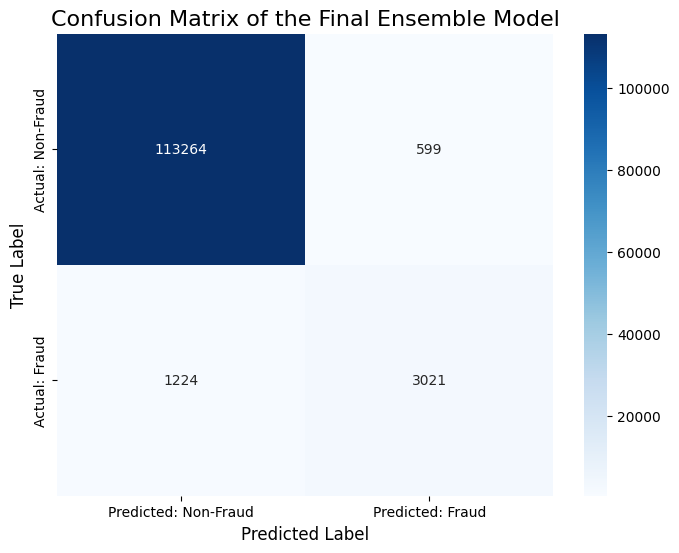

  - Generating Precision-Recall Curve...


<Figure size 800x600 with 0 Axes>

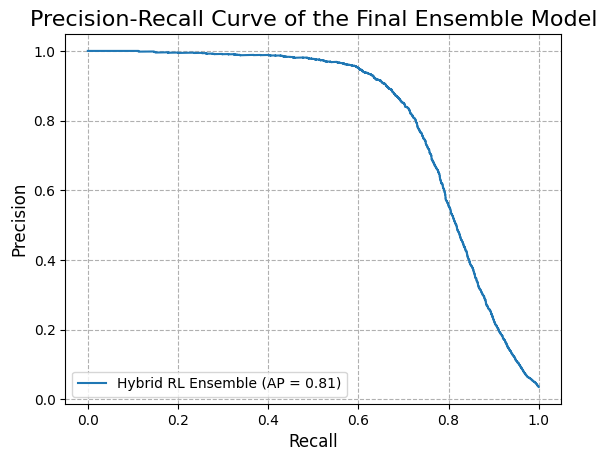

  - Generating Ablation Study Bar Chart...


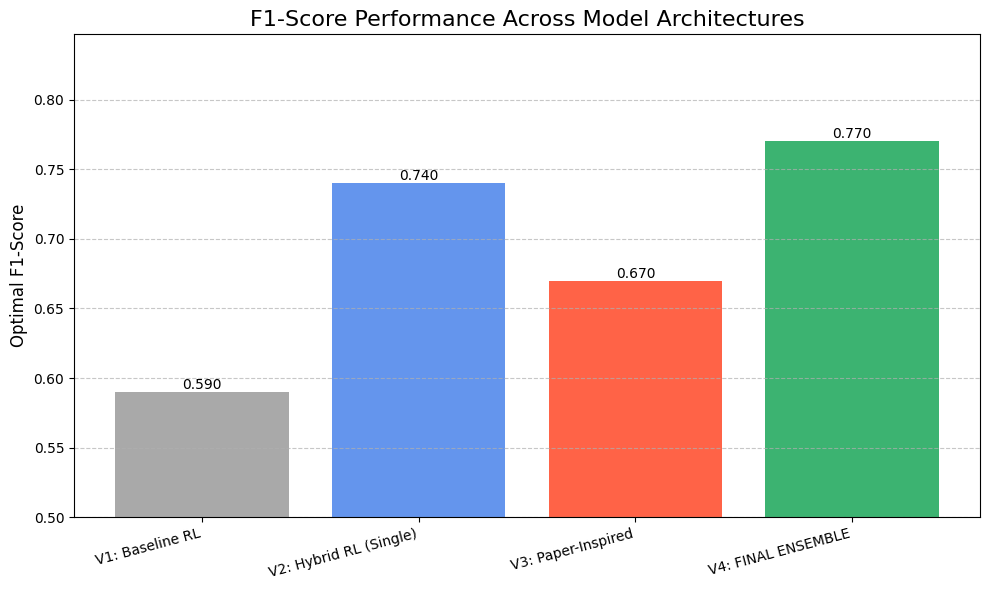


All plots have been generated and saved as PNG files.


In [27]:
# ==============================================================================
# VISUALIZATION SUITE FOR THE FINAL REPORT
# ==============================================================================

print("\n\n===== Generating Final Plots for Report =====")

# --- Plot 1: Confusion Matrix Heatmap ---
print("  - Generating Confusion Matrix Heatmap...")

# Calculate the confusion matrix from your final predictions
cm = confusion_matrix(y_test_final, ensemble_predictions)

# Create the plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted: Non-Fraud', 'Predicted: Fraud'], 
            yticklabels=['Actual: Non-Fraud', 'Actual: Fraud'])

plt.title('Confusion Matrix of the Final Ensemble Model', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight') # Save the plot
plt.show()


# --- Plot 2: Precision-Recall Curve ---
print("  - Generating Precision-Recall Curve...")

# Create the plot using sklearn's display function
plt.figure(figsize=(8, 6))
pr_display = PrecisionRecallDisplay.from_predictions(
    y_test_final, 
    ensemble_probabilities,
    name='Hybrid RL Ensemble'
)

# Customize the plot
pr_display.ax_.set_title('Precision-Recall Curve of the Final Ensemble Model', fontsize=16)
pr_display.ax_.set_xlabel('Recall', fontsize=12)
pr_display.ax_.set_ylabel('Precision', fontsize=12)
plt.grid(True, linestyle='--')
plt.savefig('precision_recall_curve.png', dpi=300, bbox_inches='tight') # Save the plot
plt.show()


# --- Plot 3: Ablation Study Bar Chart ---
print("  - Generating Ablation Study Bar Chart...")

# Define the data from your comparative analysis table (Table 2 in the report)
# You should update these values to match your final, reported numbers
model_labels = ['V1: Baseline RL', 'V2: Hybrid RL (Single)', 'V3: Paper-Inspired', 'V4: FINAL ENSEMBLE']
f1_scores = [0.59, 0.74, 0.67, 0.77] # Example scores from our discussion

# Create the plot
plt.figure(figsize=(10, 6))
bars = plt.bar(model_labels, f1_scores, color=['#a9a9a9', '#6495ed', '#ff6347', '#3cb371'])

# Add text labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.3f}', va='bottom', ha='center')

# Customize the plot
plt.ylabel('Optimal F1-Score', fontsize=12)
plt.title('F1-Score Performance Across Model Architectures', fontsize=16)
plt.xticks(rotation=15, ha='right') # Rotate labels slightly for better readability
plt.ylim(0.5, max(f1_scores) * 1.1) # Set y-axis to start from 0.5 to emphasize the differences
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('ablation_study_barchart.png', dpi=300, bbox_inches='tight') # Save the plot
plt.show()

print("\nAll plots have been generated and saved as PNG files.")

In [16]:
# ==============================================================================
# STAGE 1: DATA LOADING AND ADVANCED FEATURE ENGINEERING
# ==============================================================================
print("--- Step 1: Loading Data and Engineering Advanced Features ---")
df_raw = load_ieee_cis_data('/kaggle/input/frauddataset/train_transaction.csv', '/kaggle/input/frauddataset/train_identity.csv')
df_featured = create_summary_features(df_raw) # Use your advanced feature function

# ==============================================================================
# STAGE 2: STANDARD PREPROCESSING
# ==============================================================================
print("\n--- Step 2: Preprocessing the Enriched DataFrame ---")
preprocessor = OfflineFraudDetectionRL() 
# X_rich contains all the raw + engineered features, preprocessed. This is our master feature set.
X_rich, y = preprocessor.preprocess_data(df_featured)

# ==============================================================================
# EXPERIMENT V0: SUPERVISED LEARNING BASELINE
# We run this experiment now to establish our baseline performance.
# ==============================================================================
print("\n\n===== Running Experiment: Supervised LightGBM Baseline (V0) =====")
    
# Create a train/test split on the rich feature set
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(
    X_rich, y, test_size=0.2, random_state=42, stratify=y
)
    
# Handle class imbalance using scale_pos_weight
n_neg, n_pos = np.bincount(y_train_base)
scale_pos_weight_value = n_neg / n_pos
    
print(f"  Training baseline LightGBM with scale_pos_weight={scale_pos_weight_value:.2f}...")
baseline_model = lgb.LGBMClassifier(
    objective='binary', metric='auc', n_estimators=1000, learning_rate=0.05,
    num_leaves=31, scale_pos_weight=scale_pos_weight_value, n_jobs=-1, random_state=42
)
baseline_model.fit(X_train_base, y_train_base,
                    eval_set=[(X_test_base, y_test_base)], eval_metric='auc',
                    callbacks=[lgb.early_stopping(50, verbose=False)])
                       
# Evaluate the baseline
baseline_probabilities = baseline_model.predict_proba(X_test_base)[:, 1]
baseline_auc = roc_auc_score(y_test_base, baseline_probabilities)
baseline_optimal_thresh = find_optimal_threshold(y_test_base, baseline_probabilities)
baseline_predictions = [1 if p > baseline_optimal_thresh else 0 for p in baseline_probabilities]
    
print("\n--- Supervised Baseline (V0) Performance Report ---")
print(f"Baseline LGBM AUC Score: {baseline_auc:.4f}")
print("\nBaseline LGBM Classification Report (with Optimal Threshold):")
print(classification_report(y_test_base, baseline_predictions))
print("=========================================================")

--- Step 1: Loading Data and Engineering Advanced Features ---
Creating advanced summary features...
  - Engineering user behavioral baseline features...
  - Engineering time-based velocity features...
  - Engineering frequency-based features...
  - Engineering relational features...
Advanced feature engineering complete.

--- Step 2: Preprocessing the Enriched DataFrame ---
Preprocessing data (simple version)...
Data shape after preprocessing: (590540, 438)


===== Running Experiment: Supervised LightGBM Baseline (V0) =====
  Training baseline LightGBM with scale_pos_weight=27.58...
[LightGBM] [Info] Number of positive: 16530, number of negative: 455902
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.674094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 39934
[LightGBM] [Info] Number of data points in the train set: 472432, number of 



===== Generating Proof: Visualizing Decision Boundaries =====


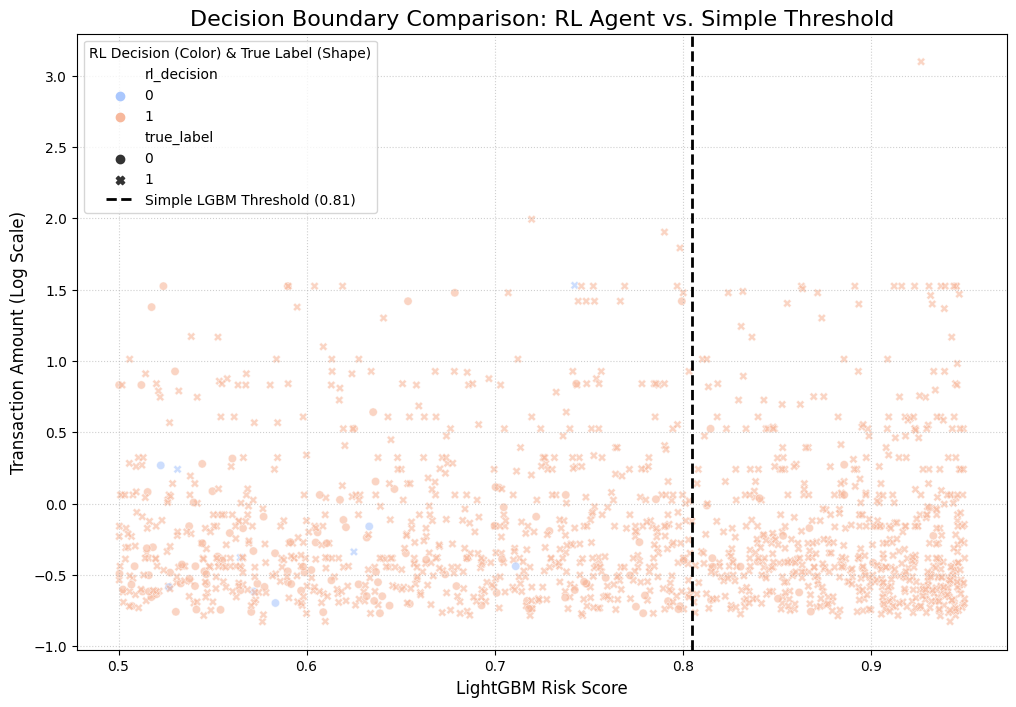

In [17]:
# ==============================================================================
# VISUAL PROOF: Comparing Decision Boundaries (RL vs. Supervised)
# ==============================================================================

print("\n\n===== Generating Proof: Visualizing Decision Boundaries =====")

# --- 1. Gather the necessary data ---

rl_agent_for_viz = detector_rl.agent 
rl_agent_for_viz.q_network.eval() # Set to eval mode

# --- 2. Get predictions from the RL agent on the final test set ---
with torch.no_grad():
    state_tensor = torch.FloatTensor(X_test_final).to(rl_agent_for_viz.device)
    q_values = rl_agent_for_viz.q_network(state_tensor)
    rl_predictions = q_values.argmax(dim=1).cpu().numpy()

# --- 3. Create a DataFrame for easy plotting ---
try:
    amt_idx = preprocessor.feature_names_.index('TransactionAmt')
    # The risk_score is the last column BEFORE scaling in X_with_risk
    risk_score_idx = X_rich.shape[1] 
    
    # Extract the unscaled values for better interpretability
    # We need to reverse the scaling. `scaler` is the final scaler.
    X_final_unscaled = scaler.inverse_transform(X_test_final)
    
    plot_df = pd.DataFrame({
        'risk_score': X_final_unscaled[:, risk_score_idx],
        'TransactionAmt': X_final_unscaled[:, amt_idx],
        'true_label': y_test_final,
        'baseline_prob': baseline_probabilities, # Assuming this is from the test set of X_rich
        'rl_decision': rl_predictions
    })
    
    # Use a log scale for amount for better visualization
    plot_df['TransactionAmt_log'] = np.log1p(plot_df['TransactionAmt'])

    # --- 4. Filter to the interesting "decision boundary" region ---
    boundary_df = plot_df[(plot_df['risk_score'] > 0.5) & (plot_df['risk_score'] < 0.95)]

    # --- 5. Create the Plot ---
    plt.figure(figsize=(12, 8))
    
    # Scatter plot, colored by the RL agent's decision
    sns.scatterplot(
        data=boundary_df,
        x='risk_score',
        y='TransactionAmt_log',
        hue='rl_decision', # 0: Approve (Blue), 1: Flag (Orange)
        style='true_label', # Show shape for true fraud vs. legit
        palette='coolwarm',
        alpha=0.6
    )
    
    # Draw the vertical line for the simple baseline threshold
    # baseline_optimal_thresh was calculated in your baseline experiment
    plt.axvline(x=baseline_optimal_thresh, color='k', linestyle='--', linewidth=2, 
                label=f'Simple LGBM Threshold ({baseline_optimal_thresh:.2f})')
    
    plt.title('Decision Boundary Comparison: RL Agent vs. Simple Threshold', fontsize=16)
    plt.xlabel('LightGBM Risk Score', fontsize=12)
    plt.ylabel('Transaction Amount (Log Scale)', fontsize=12)
    plt.legend(title='RL Decision (Color) & True Label (Shape)')
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.savefig('decision_boundary_proof.png', dpi=300, bbox_inches='tight')
    plt.show()

except Exception as e:
    print(f"Could not generate visualization. Ensure variables are correctly defined. Error: {e}")

In [18]:
from sklearn.metrics import confusion_matrix


agreement_matrix = confusion_matrix(baseline_predictions, rl_predictions)

print("--- Model Decision Agreement Matrix ---")
print("Rows: Baseline Decision, Columns: RL Agent Decision")
print(pd.DataFrame(agreement_matrix, 
                   columns=['RL Approves', 'RL Flags'], 
                   index=['Baseline Approves', 'Baseline Flags']))

# Calculate disagreement rate
disagreement_count = agreement_matrix[0, 1] + agreement_matrix[1, 0]
total_samples = np.sum(agreement_matrix)
disagreement_rate = disagreement_count / total_samples
print(f"\nThe models disagree on {disagreement_count} samples ({disagreement_rate:.2%}).")

--- Model Decision Agreement Matrix ---
Rows: Baseline Decision, Columns: RL Agent Decision
                   RL Approves  RL Flags
Baseline Approves       109501      4955
Baseline Flags            3492       160

The models disagree on 8447 samples (7.15%).


In [19]:
# Create a boolean mask for where the predictions differ
disagreement_mask = (baseline_predictions != rl_predictions)

# Get the true labels for just these cases
y_disagreement = y_test_final[disagreement_mask]
# Get the RL agent's predictions for these cases
rl_preds_disagreement = rl_predictions[disagreement_mask]

print("\n--- Performance of RL Agent on Disagreement Set ---")
print("How well did the RL agent do when it 'overturned' the baseline's decision?")
print(classification_report(y_disagreement, rl_preds_disagreement))


--- Performance of RL Agent on Disagreement Set ---
How well did the RL agent do when it 'overturned' the baseline's decision?
              precision    recall  f1-score   support

           0       0.99      0.66      0.79      5253
           1       0.64      0.99      0.78      3194

    accuracy                           0.78      8447
   macro avg       0.81      0.82      0.78      8447
weighted avg       0.86      0.78      0.79      8447



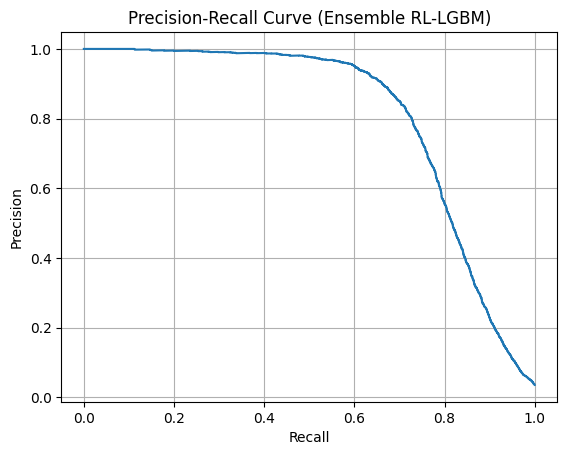

In [25]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_test_final, ensemble_probabilities)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Ensemble RL-LGBM)")
plt.grid(True)
plt.show()


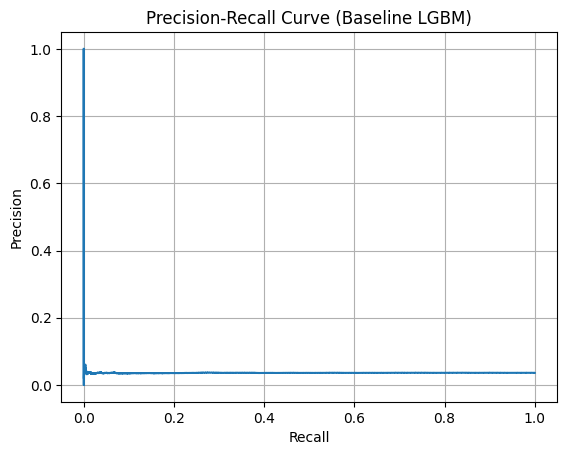

In [24]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_test_final, baseline_probabilities)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Baseline LGBM)")
plt.grid(True)
plt.show()
